# Connecting to Snowpark


In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import *
from datetime import datetime
import pandas as pd

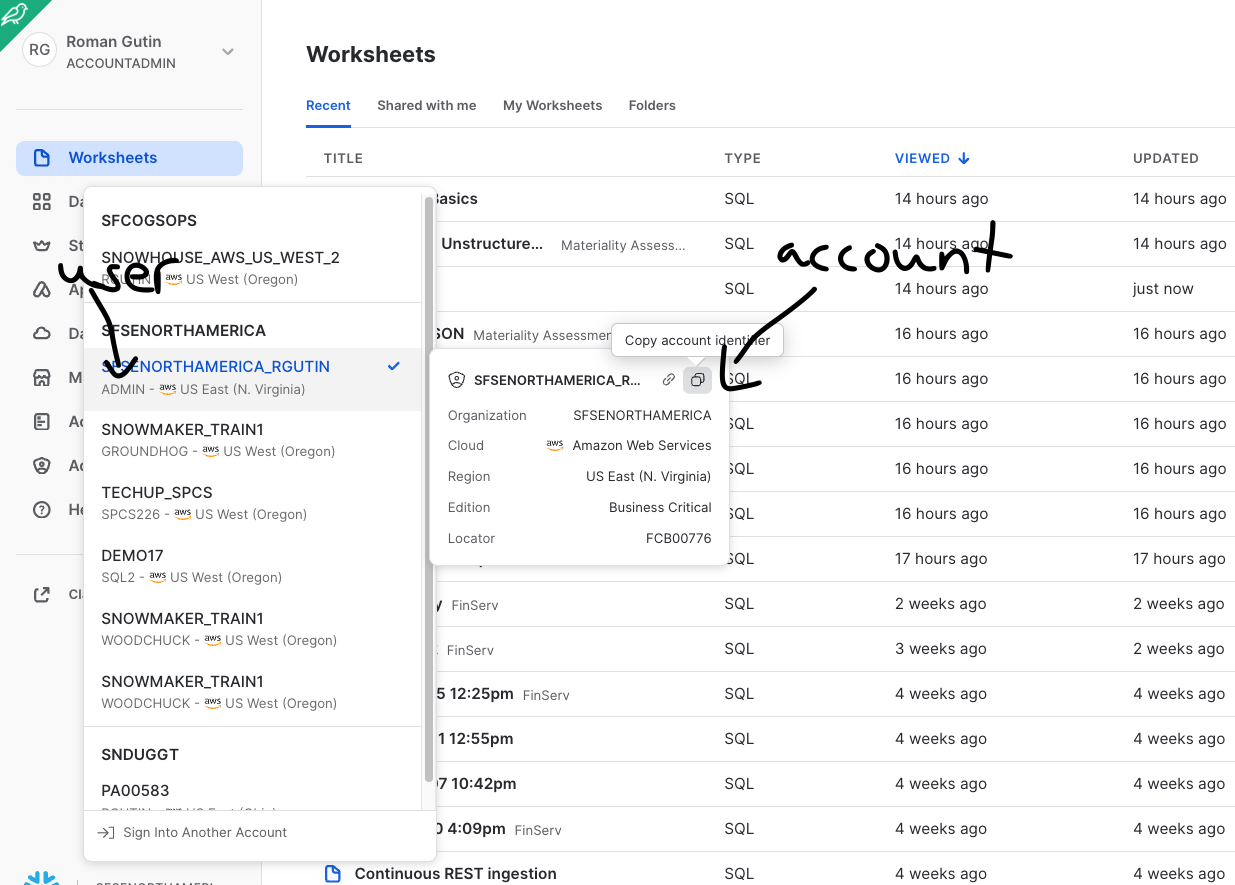

In [4]:

connection_config = {
    "account": "fcb00776.us-east-1"
    ,"user": "admin"
    ,"password": "your_password"
}

In [5]:

session = Session.builder.configs(connection_config).create()

# Exploring the Snowpark Session Object


### 1. Executing SQL

#### The Snowpark Session object is an augmented version of the raw python connector. Lets starts with how we can run SQL.

In [6]:
#Create  warehouse for the webinar
session.sql("""create or replace warehouse snowparkbasics_wh auto_suspend = 60;""").collect()
session.sql('create or replace database snowparkbasics;').collect()
session.sql('create or replace stage truck_stage;').collect()

[Row(status='Stage area TRUCK_STAGE successfully created.')]

In [7]:
print(f"Current Database: {session.get_current_database()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database: "SNOWPARKBASICS"
Current Warehouse: "SNOWPARKBASICS_WH"


### 2. Loading a CSV file with Snowpark 



In [8]:
truck_data = pd.read_csv('truck.csv')
truck_data.head()

,TRUCK_ID,MENU_TYPE_ID,PRIMARY_CITY,REGION,ISO_REGION,COUNTRY,ISO_COUNTRY_CODE,FRANCHISE_FLAG,YEAR,MAKE,MODEL,EV_FLAG,FRANCHISE_ID,TRUCK_OPENING_DATE
0,2,2,San Mateo,California,CA,United States,US,0,2015,Ford_,Step Van,0,1,2015-07-01
1,3,3,San Mateo,California,CA,United States,US,1,2004,Freightliner,MT45 Utilimaster,0,2,2015-11-01
2,4,4,San Mateo,California,CA,United States,US,1,1997,Chevrolet,P30,1,3,2019-02-01
3,5,5,San Mateo,California,CA,United States,US,1,2010,Custom,Van,1,4,2020-04-01
4,6,6,San Mateo,California,CA,United States,US,1,2010,Airstream,Trailer,0,5,2015-07-01


#### First we PUT the file in a Snowflake internal stage

In [9]:

put_result = session.file.put(local_file_name='*.csv',
                stage_location='@truck_stage')

put_result 

[PutResult(source='truck.csv', target='truck.csv.gz', source_size=42017, target_size=5888, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

#### Create a table with the same schema as our csv file and run a COPY INTO command with SQL.

In [10]:
session.sql("""CREATE OR REPLACE TABLE TRUCK1 (
    TRUCK_ID INT,
    MENU_TYPE_ID INT,
    PRIMARY_CITY VARCHAR(255),
    REGION VARCHAR,
    ISO_REGION VARCHAR,
    COUNTRY VARCHAR(255),
    ISO_COUNTRY_CODE VARCHAR(255),
    FRANCHISE_FLAG BOOLEAN,
    YEAR NUMBER,
    MAKE VARCHAR(255),
    MODEL VARCHAR(255),
    EV_FLAG BOOLEAN,
    FRANCHISE_ID NUMBER,
    TRUCK_OPENING_DATE DATE
);
 """).collect()



session.sql('COPY INTO TRUCK1 from @truck_stage file_format=(skip_header=1) on_error=continue').collect()


[Row(file='truck_stage/truck.csv.gz', status='LOADED', rows_parsed=450, rows_loaded=450, error_limit=450, errors_seen=0, first_error=None, first_error_line=None, first_error_character=None, first_error_column_name=None)]

### Now that we loaded the data, lets inspect our table with a Snowpark DataFrame.

In [11]:
#Tables and views are referenced by name 
truck_1_df = session.table("TRUCK1")
truck_1_df

In [13]:
truck_1_df.limit(5).show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2           |2               |San Mateo       |California  |CA            |United States  |US                  |False             |2015    |Ford_         |Step Van          |False      |1               |2015-07-01            |
|3           |3               |San Mateo       |California  |CA            |United State

In [14]:
truck_1_df.limit(5).to_pandas()

,TRUCK_ID,MENU_TYPE_ID,PRIMARY_CITY,REGION,ISO_REGION,COUNTRY,ISO_COUNTRY_CODE,FRANCHISE_FLAG,YEAR,MAKE,MODEL,EV_FLAG,FRANCHISE_ID,TRUCK_OPENING_DATE
0,2,2,San Mateo,California,CA,United States,US,False,2015,Ford_,Step Van,False,1,2015-07-01
1,3,3,San Mateo,California,CA,United States,US,True,2004,Freightliner,MT45 Utilimaster,False,2,2015-11-01
2,4,4,San Mateo,California,CA,United States,US,True,1997,Chevrolet,P30,True,3,2019-02-01
3,5,5,San Mateo,California,CA,United States,US,True,2010,Custom,Van,True,4,2020-04-01
4,6,6,San Mateo,California,CA,United States,US,True,2010,Airstream,Trailer,False,5,2015-07-01


## Don't want to create tables prior to loading? Who does? 

In [15]:
# Use the Snowpark session to write a pandas dataframe directly to a snowflake table with schema inference.
session.write_pandas(df = truck_data, table_name='TRUCK3', auto_create_table=True, overwrite=True)

In [16]:
#Done
session.table('TRUCK3').show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2           |2               |San Mateo       |California  |CA            |United States  |US                  |0                 |2015    |Ford_         |Step Van          |0          |1               |2015-07-01            |
|3           |3               |San Mateo       |California  |CA            |United State

## Basic Transformations, Aggregations, Joins on Snowpark DataFrames

#### How big is our fleet in every region?

In [17]:

truck_count_by_region = session.table('TRUCK3').group_by('REGION').count()

In [18]:
#Dataframe operations are converted to SQL operations automatically.
truck_count_by_region.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "REGION", count(1) AS "COUNT" FROM ( SELECT  *  FROM TRUCK3) GROUP BY "REGION"
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=13312
Operations:
1:0     ->Result  TRUCK3.REGION, COUNT(1)  
1:1          ->Aggregate  aggExprs: [COUNT(1)], groupKeys: [TRUCK3.REGION]  
1:2               ->TableScan  SNOWPARKBASICS.PUBLIC.TRUCK3  REGION  {partitionsTotal=1, partitionsAssigned=1, bytesAssigned=13312}

--------------------------------------------


#### Create a view for the above

In [19]:
truck_count_by_region.create_or_replace_view("TRUCK_FLEET_COUNT")

[Row(status='View TRUCK_FLEET_COUNT successfully created.')]

In [20]:
# Views and tables are accessed the same way in Snowpark
session.table('TRUCK_FLEET_COUNT').to_pandas().head()

,REGION,COUNT
0,California,15
1,Colorado,15
2,Washington,15
3,Massachusetts,15
4,Ontario,15


#### How many trucks in each region are older than 15 years?

In [21]:
from snowflake.snowpark.functions import col, lit, count, round as sp_round, call_builtin
from datetime import datetime
truck_snowpark_df = session.table("TRUCK3")

#Snowpark understands datetime arithmetic 
truck_snowpark_df = truck_snowpark_df.withColumn('TRUCK_AGE_YEARS', datetime.now().year - col("YEAR"))



old_truck_df = truck_snowpark_df.select('REGION','TRUCK_AGE_YEARS')\
                .filter(col('TRUCK_AGE_YEARS') >15)\
                .group_by(['REGION'])\
                .agg(count('*').alias("OLD_TRUCK_COUNT"))


old_truck_df.explain()



---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "REGION", count(1) AS "OLD_TRUCK_COUNT" FROM ( SELECT  *  FROM ( SELECT "REGION", (2023 :: INT - "YEAR") AS "TRUCK_AGE_YEARS" FROM TRUCK3) WHERE ("TRUCK_AGE_YEARS" > 15 :: INT)) GROUP BY "REGION"
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=13312
Operations:
1:0     ->Result  TRUCK3.REGION, COUNT(1)  
1:1          ->Aggregate  aggExprs: [COUNT(1)], groupKeys: [TRUCK3.REGION]  
1:2               ->Filter  (2023 - TRUCK3.YEAR) > 15  
1:3                    ->TableScan  SNOWPARKBASICS.PUBLIC.TRUCK3  REGION, YEAR  {partitionsTotal=1, partitionsAssigned=1, bytesAssigned=13312}

--------------------------------------------


In [22]:
old_truck_df.show()

------------------------------------------
|"REGION"            |"OLD_TRUCK_COUNT"  |
------------------------------------------
|California          |5                  |
|Colorado            |5                  |
|Washington          |5                  |
|Massachusetts       |4                  |
|New York            |3                  |
|Ontario             |5                  |
|British Columbia    |8                  |
|Greater London      |7                  |
|Greater Manchester  |7                  |
|Île-de-France       |8                  |
------------------------------------------



### What % of our trucks are older than 15 years per region.

#### We can reuse and join previously defined Snowpark Dataframes

In [23]:
#truck_count_by_region was defined in the last section

old_truck_df = old_truck_df.join(truck_count_by_region, 'REGION').\
                            select((sp_round((col('COUNT')-col("OLD_TRUCK_COUNT"))/col("COUNT"),2)).alias('AGED_FLEET_PERCENTAGE')
                                   ,"REGION")

In [24]:
old_truck_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT round((("COUNT" - "OLD_TRUCK_COUNT") / "COUNT"), 2) AS "AGED_FLEET_PERCENTAGE", "REGION" FROM ( SELECT  *  FROM (( SELECT "REGION" AS "REGION", "OLD_TRUCK_COUNT" AS "OLD_TRUCK_COUNT" FROM ( SELECT "REGION", count(1) AS "OLD_TRUCK_COUNT" FROM ( SELECT  *  FROM ( SELECT "REGION", (2023 :: INT - "YEAR") AS "TRUCK_AGE_YEARS" FROM TRUCK3) WHERE ("TRUCK_AGE_YEARS" > 15 :: INT)) GROUP BY "REGION")) AS SNOWPARK_LEFT INNER JOIN ( SELECT "REGION" AS "REGION", "COUNT" AS "COUNT" FROM ( SELECT "REGION", count(1) AS "COUNT" FROM ( SELECT  *  FROM TRUCK3) GROUP BY "REGION")) AS SNOWPARK_RIGHT USING (REGION)))
Logical Execution Plan:
GlobalStats:
    partitionsTotal=2
    partitionsAssigned=2
    bytesAssigned=26624
Operations:
1:0     ->Result  ROUND(((COUNT(1)) - (COUNT(1))) / (COUNT(1)), 2), TRUCK3.REGION  
1:1          ->InnerJoin  joinKey: (TRUCK3.REGION = TRUCK3.REGION)  
1:2               ->Aggregate  aggExprs: [COUNT(1)], group

In [25]:
old_truck_df.create_or_replace_view('V_AGING_FLEET')

[Row(status='View V_AGING_FLEET successfully created.')]

In [26]:
session.table('V_AGING_FLEET').sort(col("AGED_FLEET_PERCENTAGE").desc()).limit(10).to_pandas()

,AGED_FLEET_PERCENTAGE,REGION
0,0.80,New York
1,0.73,Massachusetts
2,0.67,Bavaria
3,0.67,Washington
4,0.67,Colorado
5,0.67,California
6,0.67,Ontario
7,0.67,Kantō
8,0.60,Rio de Janeiro estado
9,0.60,Brandenburg


### Alternatively, you can materizalize an aggregation to a table using .write()

In [27]:
#We can still reuse old_truck_df and write to a new and yet to be created table 

old_truck_df.sort(col("AGED_FLEET_PERCENTAGE").desc())\
            .write.mode('overwrite').save_as_table('AGING_FLEET_BY_REGION')

In [28]:
session.table("AGING_FLEET_BY_REGION").show()

-----------------------------------------------
|"AGED_FLEET_PERCENTAGE"  |"REGION"           |
-----------------------------------------------
|0.80                     |New York           |
|0.73                     |Massachusetts      |
|0.67                     |Colorado           |
|0.67                     |Washington         |
|0.67                     |Ontario            |
|0.67                     |California         |
|0.67                     |Bavaria            |
|0.67                     |Kantō              |
|0.60                     |Cairo Governorate  |
|0.60                     |Seoul Capital      |
-----------------------------------------------



# Python Stored Procedures with Pandas operations



Suppose our business generates data in a format not supported by COPY INTO, such as Excel. We would normally run an ETL proccess externally to convert .xslx to .csv or .parquet.

With Snowpark, **you can now convert and/or ingest most file formats without needing a local cluster**.

To process files with Python on Snowflake compute, we are going to:
1. Introduce the concept of **Scoped File URLS and Dynamic File Access**
2. Create a **Stored Procedure**  which processes those files with pandas and writes to Snowflake.


#### Local use of Dynamic File Access is not GA yet. This gives us the opportunity to demonstrate:
1. How to leverage Snowpark within Snowsight.
2. The power of creating a "Semantic Layer" that can we be reused.

In [29]:
#Lets take a look at a sample excel file
pd.read_excel("MultSheetExcelFile.xlsx", sheet_name= None).keys()

dict_keys(['Instructions', 'SalesOrders', 'MyLinks'])

In [30]:
stage_path  = "@truck_excel_stage"
session.sql(f'create or replace stage truck_excel_stage').collect()

[Row(status='Stage area TRUCK_EXCEL_STAGE successfully created.')]

In [31]:
session.file.put('MultSheetExcelFile.xlsx', stage_path, auto_compress=False)

[PutResult(source='MultSheetExcelFile.xlsx', target='MultSheetExcelFile.xlsx', source_size=61720, target_size=61728, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [82]:



def ingest_xslx(session:Session , scoped_file_url:str) -> Variant:
    from snowflake.snowpark.files import SnowflakeFile
    import pandas as pd
    with SnowflakeFile.open(scoped_file_url, 'rb') as f:
            #Excel files can have multiple sheets 
        for sheet_name , data in pd.read_excel(f, sheet_name = None).items():
            data = data.dropna()
            sp_df = session.create_dataframe(data)
            sp_df.write.mode("overwrite").save_as_table(sheet_name.capitalize())
    return True

In [83]:
session.sproc.register( func =  ingest_xslx,
                       name = 'ingest_xlsx',
                       is_permanent=True,
                       replace = True,
                       stage_location=stage_path,
                       packages = ['snowflake-snowpark-python', 'pandas','openpyxl' ])

The version of package 'openpyxl' in the local environment is 3.1.2, which does not fit the criteria for the requirement 'openpyxl'. Your UDF might not work when the package version is different between the server and your local environment.


In [84]:
session.sql(f"SELECT BUILD_SCOPED_FILE_URL({stage_path}, 'MultSheetExcelFile.xlsx') as file_path;").to_pandas()

,FILE_PATH
0,https://fcb00776.us-east-1.privatelink.snowfla...


In [86]:
session.sql(f"call ingest_xlsx(BUILD_SCOPED_FILE_URL({stage_path}, 'MultSheetExcelFile.xlsx'));").collect()

[Row(INGEST_XLSX='true')]

In [87]:
session.table('SALESORDERS').show()

------------------------------------------------------------------------------------------------
|"OrderDate"       |"Region"  |"Rep"     |"Item"  |"Units"  |"Unit Cost"  |"Total"             |
------------------------------------------------------------------------------------------------
|1609891200000000  |East      |Jones     |Pencil  |95       |1.99         |189.05              |
|1611360000000000  |Central   |Kivell    |Binder  |50       |19.99        |999.4999999999999   |
|1612828800000000  |Central   |Jardine   |Pencil  |36       |4.99         |179.64000000000001  |
|1614297600000000  |Central   |Gill      |Pen     |27       |19.99        |539.7299999999999   |
|1615766400000000  |West      |Sorvino   |Pencil  |56       |2.99         |167.44              |
|1617235200000000  |East      |Jones     |Binder  |60       |4.99         |299.40000000000003  |
|1618704000000000  |Central   |Andrews   |Pencil  |75       |1.99         |149.25              |
|1620172800000000  |Central   